In [8]:
# from qubeui import Qube
# from qubeui import display, QubeSetupPanel, QubeLoadConfigPanel

# QUBE = Qube()
# display(QubeLoadConfigPanel(QUBE))
# display(QubeSetupPanel(QUBE))

In [10]:
#'0d5f85.bit'
# QUBE.config['bitfile'] = '067d1e.bit'
# QUBE.config['ipfpga'] = '10.1.0.6'

In [59]:
import qubelsi.qube

o = qubelsi.qube.Qube('10.5.0.23', './adi_api_mod')
#o.do_init(bitfile='/home/qube/bin/067d1e.bit', message_out=True)
#o.do_init(bitfile='/home/qube/bin/0d5f85.bit', message_out=True)
o.do_init(message_out=True)
#o.do_init(bitfile='/home/qube/deprecated/20220408/bin/067d1e.bit', message_out=True)

init LMX2594 for ctrl/readout
init LMX2594 for AD9082
init ADRF6780
init AD5328
init GPIOs for RF-switches
init AD9082
Hello World 

0x4=82
adi_ad9081_device_reset(...)
adi_ad9081_device_init(...)
api v1.0.6 commit 6eb6c66 for ad9081 
host is using little endian mode.
adi_ad9081_device_spi_config(...)
adi_ad9081_device_reg8_access_check(...)
adi_ad9081_device_power_status_check(...)
adi_ad9081_device_clk_config_set(...)
adi_ad9081_device_boot_pre_clock(...)
adi_ad9081_device_chip_id_get(...)
device is ad9082 r3
adi_ad9081_device_laminate_id_get(...)
adi_ad9081_device_die_id_get(...)
adi_ad9081_dac_digital_logic_enable_set(...)
adi_ad9081_dac_spi_enable_set(...)
adi_ad9081_device_aclk_receiver_enable_set(...)
adi_ad9081_device_clk_pll_enable_set(...)
adi_ad9081_adc_clk_div_set(...)
adi_ad9081_device_clk_up_div_set(...)
adi_ad9081_device_boot_post_clock(...)
adi_ad9081_adc_core_analog_regs_enable_set(...)
adi_ad9081_adc_core_analog_regs_enable_set(...)
adi_ad9081_dac_spi_enable_set(...)


In [60]:
print(o.ad9082[0].get_jesd_status())
print(o.ad9082[1].get_jesd_status())

[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]
[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]


In [65]:
import qubecalib as qc
import pickle

PORT_ID = 0
VATT = 0x300
TYPE = 'A'

qube = QUBE.qube
port = qc.new_port_handler(qube)

if TYPE == 'A':
    qube.adrf6780[0].set_usb()
    qube.adrf6780[1].set_usb()
    qube.adrf6780[2].set_lsb()
    qube.adrf6780[3].set_lsb()
    qube.adrf6780[4].set_lsb()
    qube.adrf6780[5].set_lsb()
    qube.adrf6780[6].set_usb()
    qube.adrf6780[7].set_usb()
else:
    qube.adrf6780[0].set_lsb()
    qube.adrf6780[1].set_lsb()
    qube.adrf6780[2].set_lsb()
    qube.adrf6780[3].set_lsb()
    qube.adrf6780[4].set_lsb()
    qube.adrf6780[5].set_lsb()
    qube.adrf6780[6].set_lsb()
    qube.adrf6780[7].set_lsb()

# ms2038 = instruments.MS2038_SPA(visa)
# ms2038.write(':INIT:CONT OFF')

#fname = 'Qube{}_{}_Port{}_{}_coarse.pickle'.format(QUBE, QUBE_ID, PORT_ID, hex(VATT))
result = []

# Readout 9500 - 11000
#   IF 1300 - 2000
#   LO 8200 - 8500 

def set_lo(port, mhz):
    qc.set_lmx2594_freq_100M(port.losc, int(mhz*1e-2))

def set_nco(port, mhz):
    ifdac = port.ifdac
    ifdac.ad9082.set_nco(ch=ifdac.ch, freq=mhz*1e+6)

def set_lo_nco(port, lo, nco):
    set_lo(port, lo)
    set_nco(port, nco)

FL = 8200
FI = 1800
set_lo_nco(port[0], FL, FI)
set_lo_nco(port[2], FL, FI)
set_lo_nco(port[11], FL, FI)
set_lo_nco(port[13], FL, FI)

for k, v in port.items():
    qc.set_vatt(v.upconv.vatt, VATT)

NameError: name 'QUBE' is not defined

The number of capture words = 1024 (= 4096 samples)


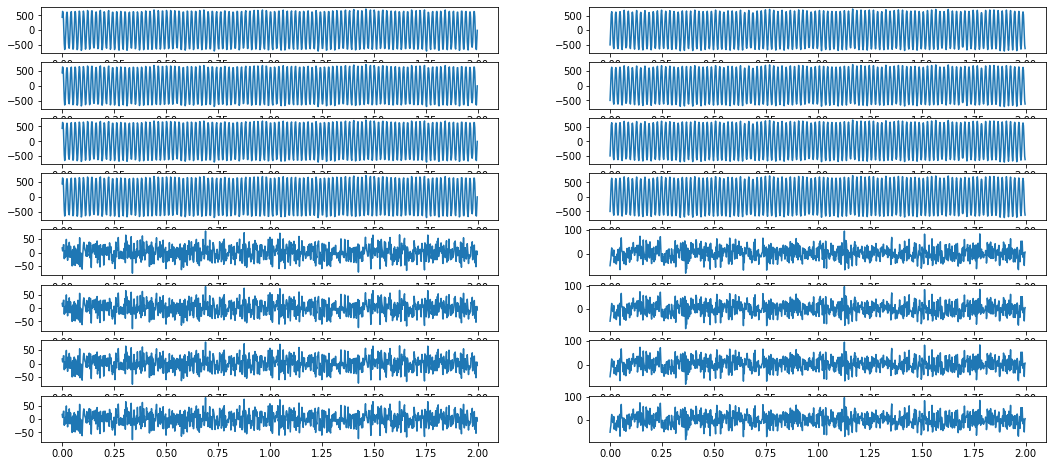

In [117]:
import e7awg_sw.examples.recv.recv as m
from e7awgsw import CaptureModule, CaptureParam

def recv(num_capture_words, capture_modules, use_labrad, server_ip_addr):
    capture_units = CaptureModule.get_units(*capture_modules)
    with m.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl:
        # 初期化
        cap_ctrl.initialize(*capture_units)
        # キャプチャパラメータの設定
        m.set_capture_params(cap_ctrl, num_capture_words, capture_units)
        # キャプチャスタート
        cap_ctrl.start_capture_units(*capture_units)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        m.check_err(cap_ctrl, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = m.get_capture_data(cap_ctrl, capture_units)
    return capture_unit_to_capture_data
        # 波形保存
        #save_sample_data('capture', CaptureCtrl.SAMPLING_RATE, capture_unit_to_capture_data)
        #print('end')


#m.IP_ADDR = QUBE.config['ipfpga']
#m.IP_ADDR = '10.1.0.6'
m.IP_ADDR = '10.1.0.23'
#m.IP_ADDR = '10.1.0.29'
num_capture_words = 1024
capture_modules = CaptureModule.all()
server_ip_addr = 'localhost'

print("The number of capture words = {} (= {} samples)".format(
    num_capture_words,
    num_capture_words * CaptureParam.NUM_SAMPLES_IN_ADC_WORD))

d = recv(num_capture_words, capture_modules, False, server_ip_addr)

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

o = [np.array(v) for k, v in d.items()]

# Capture 1 が Port 1
# Capture 0 が Port 12

sampling_rate = m.CaptureCtrl.SAMPLING_RATE
time = np.linspace(0, 1000000 * o[-1].shape[0] / sampling_rate, o[-1].shape[0], endpoint=False)

f, axs = plt.subplots(8,2, figsize=(18,8))
for i, v in enumerate(o):
    axs[i,0].plot(time[:1000], v[:,0][:1000])
    axs[i,1].plot(time[:1000], v[:,1][:1000])

In [98]:
[k for k,v in d.items()]

[<CaptureUnit.U0: 0>,
 <CaptureUnit.U1: 1>,
 <CaptureUnit.U2: 2>,
 <CaptureUnit.U3: 3>,
 <CaptureUnit.U4: 4>,
 <CaptureUnit.U5: 5>,
 <CaptureUnit.U6: 6>,
 <CaptureUnit.U7: 7>]

In [42]:
max(v[:,0]), min(v[:,0])

(6859.0, -6910.0)

In [2]:
import inspect
print(inspect.getsource(m))

"""
信号処理モジュールを全て無効にしてキャプチャのみ動かします.
"""
import sys
import os
import pathlib
import argparse

lib_path = str(pathlib.Path(__file__).resolve().parents[2])
sys.path.append(lib_path)
from e7awgsw import *
from e7awgsw.labrad import *

IP_ADDR = '10.0.0.16'
CAPTURE_DELAY = 100
SAVE_DIR = "result_recv/"

def set_capture_params(cap_ctrl, num_capture_words, capture_units):
    capture_param = gen_capture_param(num_capture_words)
    for captu_unit_id in capture_units:
        cap_ctrl.set_capture_params(captu_unit_id, capture_param)


def gen_capture_param(num_capture_words):
    capture_param = CaptureParam()
    capture_param.num_integ_sections = 1
    capture_param.add_sum_section(num_capture_words, 1) # 総和区間を 1 つだけ定義する
    capture_param.capture_delay = CAPTURE_DELAY
    return capture_param


def get_capture_data(cap_ctrl, capture_units):
    capture_unit_to_capture_data = {}
    for capture_unit_id in capture_units:
        num_captured_samples = cap_ctrl.num_captured_samples(capture_unit_

In [6]:
import inspect
print(inspect.getsource(qubelsi.ad9082))

import os
import subprocess

import qubelsi.udpsendrecv

class AD9082:

    def __init__(self, addr, path, chip):
        self.addr = addr
        self.chip = str(chip)
        self.path = path
        self.handle = qubelsi.udpsendrecv.UDPSendRecv(addr, path)

    def _setenv(self):
        os.environ['TARGET_ADDR'] = self.addr
        os.environ['AD9082_CHIP'] = self.chip
    
    def read_info(self):
        self._setenv()
        ret = subprocess.check_output("{}/src/print_ad9082_info".format(self.path), encoding='utf-8')
        return ret

    def set_nco(self, freq, ch, adc_mode=False, fine_mode=False):
        self._setenv()
        cmd = ["{}/src/set_nco".format(self.path),
               "--channel={}".format(ch),
               "--freq={}".format(freq),
        ]
        if adc_mode:
            cmd.append("--adc-mode")
        if fine_mode:
            cmd.append("--fine-mode")
        ret = subprocess.check_output(cmd, encoding='utf-8')
        return ret

    def set_xbar(